# Assignment 4

In this assignment, you'll combine the assignment 3 data set with nutrition data from the [USDA Food Composition Databases](https://ndb.nal.usda.gov/ndb/search/list). The CSV file `fresh.csv` contains the fresh fruits and vegetables data you extracted in assignment 3.

The USDA Food Composition Databases have a [documented](https://ndb.nal.usda.gov/ndb/doc/index) web API that returns data in JSON format . You need a key in order to use the API. Only 1000 requests are allowed per hour, so it would be a good idea to use [caching][requests_cache].

[Sign up for an API key here](https://api.data.gov/signup/). The key will work with any Data.gov API. You may need the key again later in the quarter, so make sure you save it.

These modules may be useful:

* [requests](http://docs.python-requests.org/en/master/user/quickstart/)
* [requests_cache][]
* [urlparse](https://docs.python.org/2/library/urlparse.html)
* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

[requests_cache]: https://pypi.python.org/pypi/requests-cache

__Exercise 1.1.__ Read the [search request documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-SEARCH.md), then write a function called `ndb_search()` that makes a search request. The function should accept the search term as an argument. The function should return the search result items as a list (for 0 items, return an empty list).

Note that the search url is: `https://api.nal.usda.gov/ndb/search`

As an example, a search for `"quail eggs"` should return this list:

```python
[{u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'CHAOKOH, QUAIL EGG IN BRINE, UPC: 044738074186',
  u'ndbno': u'45094707',
  u'offset': 0},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'L&W, QUAIL EGGS, UPC: 024072000256',
  u'ndbno': u'45094890',
  u'offset': 1},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'BUDDHA, QUAIL EGGS IN BRINE, UPC: 761934535098',
  u'ndbno': u'45099560',
  u'offset': 2},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u'GRAN SABANA, QUAIL EGGS, UPC: 819140010103',
  u'ndbno': u'45169279',
  u'offset': 3},
 {u'ds': u'BL',
  u'group': u'Branded Food Products Database',
  u'name': u"D'ARTAGNAN, QUAIL EGGS, UPC: 736622102630",
  u'ndbno': u'45178254',
  u'offset': 4},
 {u'ds': u'SR',
  u'group': u'Dairy and Egg Products',
  u'name': u'Egg, quail, whole, fresh, raw',
  u'ndbno': u'01140',
  u'offset': 5}]
```

As usual, make sure you document and test your function.

In [146]:
import requests
import requests_cache
requests_cache.install_cache('cache')

def ndb_search(q, ds):
    """
    Return a list of the search result items.
    Args:
    q(string):Search term.
    ds(string):Data source. Must be either 'Branded Food Products' or 'Standard Reference'
    Return:
    response:Search results.
    """
    url_base = 'https://api.nal.usda.gov/ndb/search'
    response = requests.get(url_base,params = {'format':'json', 'q':q, 'ds':ds, 'api_key':'8lQ4MePgdgKYpOLVBc05lKCCucgtCvnUjGGyo56T'})
    if 'errors' not in response.json():
        return response.json()['list']['item']
    else: return []

__Exercise 1.2.__ Use your search function to get NDB numbers for the foods in the `fresh.csv` file. It's okay if you don't get an NDB number for every food, but try to come up with a strategy that gets most of them. Discuss your strategy in a short paragraph.

Hints:

* The foods are all raw and unbranded.
* You can test search terms with the [online search page](https://ndb.nal.usda.gov/ndb/search/list).
* You can convert the output of `ndb_search()` to a data frame with `pd.DataFrame()`.
* The string methods for [Python](https://docs.python.org/2/library/stdtypes.html#string-methods) and [Pandas](http://pandas.pydata.org/pandas-docs/stable/text.html#method-summary) are useful here. It's okay if you use _simple_ regular expressions in the Pandas methods, although this exercise can be solved without them.
* You can merge data frames that have a column in common with `pd.merge()`.

__Strategy__:
1. Reformat the names of foods to get better search results. There are two situation we need to reformat their names.
 - some food names involve "_", i.e. lettuce_iceberg, then remove the underscore.
 - some food with same name but in different group, i.e. cucumber with peel & cucumber peeled, then assign them to the exactly detailed names, i.e. cucumber with peel, cucumber peeled.
2. The requests set data source as Standard Reference to target unbranded foods.    
3. In the requests, "food, raw" is used as term to search to narrow the raw foods.  

As for the situations where multiple records match one search term. Assuming the first record is in high relevence after observation of the results, we keep all the first records as the search results.

In [147]:
import pandas as pd
fresh = pd.read_csv('fresh.csv')
fresh.loc[25,'food'] = 'cucumbers, with peel'
fresh.loc[26,'food'] = 'cucumbers, peeled'
fresh.loc[36,'food'] = 'cabbage, green'
fresh.loc[37,'food'] = 'cabbage, red'
foodnames = [food.replace('_', ' ') for food in fresh['food']]

In [148]:
def ndb_filter(food):
    """
    Return the first record of searched item.
    Arg:
    response:search results."""
    response = ndb_search(food + ', raw', ds = 'Standard Reference')
    if len(response) != 0:
        return response[0]
    else: return {}

In [149]:
ndb_nums = pd.DataFrame([ndb_filter(food) for food in foodnames])

After checking the search results, the data of tangerines and cabbage_green is not desired. Then I changed them mannually. But there is still missing value of kiwi. 

In [150]:
ndb_nums.loc[2,:] = pd.DataFrame(ndb_search('tangerines, raw', 'Standard Reference')).loc[1,:]
ndb_nums.loc[36,:] = pd.DataFrame(ndb_search('cabbage, raw', 'Standard Reference')).loc[1,:]
ndb_nums.head()

,ds,group,name,ndbno,offset
0,SR,Fruits and Fruit Juices,"Watermelon, raw",09326,0
1,SR,Fruits and Fruit Juices,"Melons, cantaloupe, raw",09181,0
2,SR,Fruits and Fruit Juices,"Tangerines, (mandarin oranges), raw",09218,1
3,SR,Fruits and Fruit Juices,"Strawberries, raw",09316,0
4,SR,Fruits and Fruit Juices,"Plums, raw",09279,0


In [151]:
fresh['NDBNo'] = ndb_nums['ndbno']
fresh['value'] = fresh['yield'] / fresh['price_per_lb'] # add the value of food: the amout that $1 can buy
fresh.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,NDBNo,value
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit,09326,1.559632
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit,09181,0.951717
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit,09218,0.537025
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit,09316,0.398506
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit,09279,0.514388


__Exercise 1.3.__ Read the [food reports V2 documentation](https://ndb.nal.usda.gov/ndb/doc/apilist/API-FOOD-REPORTV2.md), then write a function called `ndb_report()` that requests a _basic_ food report. The function should accept the NDB number as an argument and return the list of nutrients for the food.

Note that the report url is: `https://api.nal.usda.gov/ndb/V2/reports`

For example, for `"09279"` (raw plums) the first element of the returned list should be:

```python
{u'group': u'Proximates',
 u'measures': [{u'eqv': 165.0,
   u'eunit': u'g',
   u'label': u'cup, sliced',
   u'qty': 1.0,
   u'value': u'143.93'},
  {u'eqv': 66.0,
   u'eunit': u'g',
   u'label': u'fruit (2-1/8" dia)',
   u'qty': 1.0,
   u'value': u'57.57'},
  {u'eqv': 151.0,
   u'eunit': u'g',
   u'label': u'NLEA serving',
   u'qty': 1.0,
   u'value': u'131.72'}],
 u'name': u'Water',
 u'nutrient_id': u'255',
 u'unit': u'g',
 u'value': u'87.23'}
```

Be sure to document and test your function.

In [152]:
def ndb_report(NDBNo):
    """
    Return a basic food report.
    Arg:
    NDBNo(string): NDB number of a food.
    """
    url_base = 'https://api.nal.usda.gov/ndb/V2/reports'
    response = requests.get(url_base, params = {'ndbno':NDBNo, 'api_key':'8lQ4MePgdgKYpOLVBc05lKCCucgtCvnUjGGyo56T'})
    return response.json()['foods'][0]['food']['nutrients']

__Exercise 1.4.__ Which foods provide the best combination of price, yield, and nutrition? You can use kilocalories as a measure of "nutrition" here, but more a detailed analysis is better. Use plots to support your analysis.

Since our objects to analize are fruit and vegetebles, it is necessary to obtain the nutriens of vitamins and vegetables besides energy. Therefore, I calculate the sum of vitamins and vegetables of each food for further analysis purpose.

In [153]:
import numpy as np
def get_nutrition(NDBNo):
    if type(NDBNo) != unicode: # the type of NDBNo in data frame fresh is unicode
        vm_sum = np.nan
        energy = np.nan
    else:
        rpt = pd.DataFrame(ndb_report(NDBNo))
        rpt['value'] = rpt['value'].convert_objects(convert_numeric=True)
        energy = rpt[rpt.name == 'Energy']['value'].item()
        V_M = rpt[rpt.group.isin(['Minerals','Vitamins'])]
        V_M = V_M[~V_M.unit.isin(['IU'])]
        vm_sum = sum(V_M[V_M.unit == 'mg']['value']) + sum(V_M[V_M.unit != 'mg']['value'])/1000 #unity the unit to mg
    return energy, vm_sum

In [154]:
nutri = pd.DataFrame([get_nutrition(ndbnum) for ndbnum in fresh['NDBNo']])
fresh['energy(kcal)'] = nutri.loc[:,1]
fresh['vitamins&minerals(mg)'] = nutri.loc[:,0]
fresh.head()

,form,price_per_lb,yield,lb_per_cup,price_per_cup,food,type,NDBNo,value,energy(kcal),vitamins&minerals(mg)
0,Fresh1,0.333412,0.52,0.330693,0.212033,watermelon,fruit,09326,1.559632,149.7981,30
1,Fresh1,0.535874,0.51,0.374786,0.393800,cantaloupe,fruit,09181,0.951717,357.1985,34
2,Fresh1,1.377962,0.74,0.407855,0.759471,tangerines,fruit,09218,0.537025,264.7180,53
3,Fresh1,2.358808,0.94,0.319670,0.802171,strawberries,fruit,09316,0.398506,267.1462,32
4,Fresh1,1.827416,0.94,0.363763,0.707176,plums,fruit,09279,0.514388,196.5584,46


Now I have three measurments to compare these foods. 
1. Energy in kilocalories
2. Total amout of vitamins and minerals in mg/100g
3. Value defined by ratio of yield and price
The distributions of the three measurment show there is less variability in total amount of vitamins and minerals.

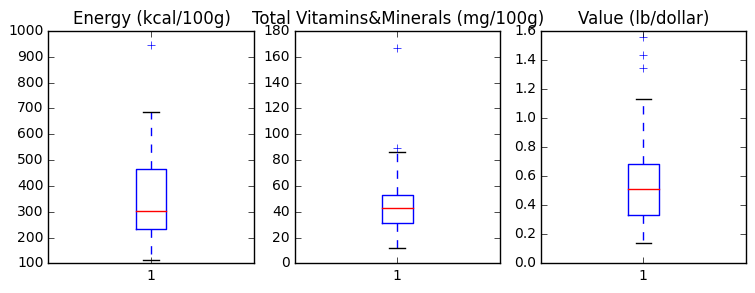

In [155]:
plt.figure().set_size_inches(9,3)
plt.subplot(1,3,1)
plt.boxplot(fresh['energy(kcal)'])
plt.title('Energy (kcal/100g)')

plt.subplot(1,3,2)
plt.boxplot(fresh['vitamins&minerals(mg)'])
plt.title('Total Vitamins&Minerals (mg/100g)')

plt.subplot(1,3,3)
plt.boxplot(fresh['value'])
plt.title('Value (lb/dollar)')

plt.show()

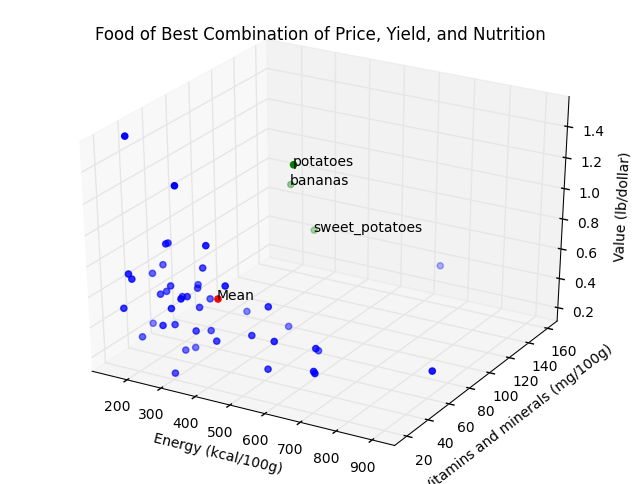

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = fig.add_subplot(111, projection = '3d')

ax.set_xlabel('Energy (kcal/100g)')
ax.set_ylabel('Vitamins and minerals (mg/100g)')
ax.set_zlabel('Value (lb/dollar)')
ax.set_xlim([min(fresh['energy(kcal)']),max(fresh['energy(kcal)'])])
ax.set_ylim([min(fresh['vitamins&minerals(mg)']),max(fresh['vitamins&minerals(mg)'])])
ax.set_zlim([min(fresh['value']),max(fresh['value'])])
plt.title('Food of Best Combination of Price, Yield, and Nutrition')

t1 = fresh[fresh['energy(kcal)'] > np.mean(fresh['energy(kcal)'])]
t2 = t1[t1['vitamins&minerals(mg)'] > np.mean(fresh['vitamins&minerals(mg)'])]
best = t2[t2['value'] > np.mean(fresh['value'])] # best food win in three aspect of value, total vitamins and minarals and energy
rest = fresh[~fresh['food'].isin(['bananas', 'potatoes','sweet_potatoes'])] # rest of the food excluding best food

ax.scatter(rest['energy(kcal)'], rest['vitamins&minerals(mg)'], rest['value'], color = 'blue')
ax.scatter(np.mean(fresh['energy(kcal)']), np.mean(fresh['vitamins&minerals(mg)']), np.mean(fresh['value']), color = 'red')
ax.text(np.mean(fresh['energy(kcal)']), np.mean(fresh['vitamins&minerals(mg)']), np.mean(fresh['value']), 'Mean')
ax.scatter(best['energy(kcal)'], best['vitamins&minerals(mg)'], best['value'], color = 'green')

for label,x,y,z in zip(best['food'], best['energy(kcal)'], best['vitamins&minerals(mg)'],best['value']):
    ax.text(x, y, z, label)

plt.show()

In the above plot, the red point is the mean of three measurements. As the green points show, potatoes, bananas and sweet potatoes are the best combination of price, yield and nutrition since they are above the average.